### Data preparation of DICOM images 

In [1]:
# import libraries
import pydicom
import pydicom.data

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import rescale

from pickle import dump
import os, re
import pprint

#### get file paths in subdirectories: 

In [2]:
def get_path_mask(path, mask_dir):
    """writes filepaths of livermasks in subdirectory of path to list, adds suffix per patient. Returns list."""
    paths_mask = []
    suffix = 1
    for fn in os.listdir(path):
        if not fn.endswith(('.DS_Store', '.zip')):           
            for fn2 in os.listdir(f"{path}{fn}"):  
                if fn2 == 'MASKS_DICOM':
                    for fn3 in os.listdir(f"{path}{fn}/{fn2}"):
                        
                        if fn3 == mask_dir:
                            for fn4 in os.listdir(f"{path}{fn}/{fn2}/{fn3}"):
                                mask_path = os.path.join( f'{path}{fn}/{fn2}/{fn3}', fn4 + '_' + str(suffix))                                
                                paths_mask.append(mask_path)
                    suffix = suffix + 1 
    return paths_mask

In [3]:
path = "/Users/krystanafoh/datasets/3Dircadb1/"
mask_dir = 'liver'
path_list_mask = get_path_mask(path, mask_dir)

In [4]:
def get_path_orig(path):
    """writes filepaths of original patient scans in subdirectory of path to list, adds suffix per patient. Returns list."""
    paths_orig = []
    suffix = 1
    for fn in os.listdir(path):
        if not fn.endswith(('.DS_Store', '.zip')):            
            for fn2 in os.listdir(f"{path}{fn}"):  
                if fn2 == 'PATIENT_DICOM':
                    for fn3 in os.listdir(f"{path}{fn}/{fn2}"):
                                orig_path = os.path.join( f'{path}{fn}/{fn2}/', fn3 + '_' + str(suffix))
                                paths_orig.append(orig_path)                               
            suffix = suffix + 1 
    return paths_orig

In [5]:
path = "/Users/krystanafoh/datasets/3Dircadb1/"
path_list_orig = get_path_orig(path)

#### create dataframe of filepaths

In [6]:
def get_df(paths_originals:list, paths_masks:list):
    """creates df, lists of paths of originals and masks to columns 'original' and 'mask'"""
    df = pd.DataFrame(list(zip(paths_originals, paths_masks)), 
               columns =['original', 'mask']) 
    return df

In [7]:
df = get_df(path_list_orig, path_list_mask)

In [8]:
# split of 1 patient (patient no.2 ) of original data, data now 19 of 20 patients
df_new = df.iloc[172:]

In [9]:
df_patient2 = df.iloc[:172]

In [ ]:
# save dataframe of patient 2: 
df_patient2.to_pickle('./patient2.hdf')

#### train test split:  

In [10]:
# train-test-split on data of 19 patients (small test split, as patient#2 was cut off from original data as test data)
X = df_new['original']
y = df_new['mask']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.95, random_state=42)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2518,), (2518,), (133,), (133,))

#### preprocess data (19 patients) 

#### create arrays out of dicoms:

In [12]:
def to_arrays_list(split_df):
    """reads in files from paths in df, converts them to pixel_arrays, returns list of pixel arrays"""
    im_list = []
    
    for i in range(len(split_df)):
    
        ds = pydicom.read_file(split_df.iloc[i].rsplit('_', 1)[0])
        data = ds.pixel_array
        
        im_list.append(data)
        
    return im_list


train data: 

In [13]:
X_train_arrays = to_arrays_list(X_train)

In [14]:
y_train_arrays = to_arrays_list(y_train)

test data: 

In [15]:
X_test_arrays = to_arrays_list(X_test)

In [16]:
y_test_arrays = to_arrays_list(y_test)

####  downsampling images to 128*128 pixels for reducing training time: 

In [17]:
# downsample all images in list: 
def downsampling(list):
    
    ds_img_list = []
    
    for array in list: 
        
        array = array[::4, ::4]
        ds_img_list.append(array)
        
    return ds_img_list

train data: 

In [18]:
X_train_arrays = downsampling(X_train_arrays)

In [19]:
y_train_arrays = downsampling(y_train_arrays)

test data: 

In [20]:
X_test_arrays = downsampling(X_test_arrays)

In [21]:
y_test_arrays = downsampling(y_test_arrays)

#### create array of arrays:

In [22]:
def to_array_array(list_of_arrays:list):
    array = np.asanyarray(list_of_arrays)
    return array

train data: 

In [23]:
orig_train_array = to_array_array(X_train_arrays)

In [24]:
masks_train_array = to_array_array(y_train_arrays)

test data: 

In [25]:
orig_test_array = to_array_array(X_test_arrays)

In [26]:
masks_test_array = to_array_array(y_test_arrays)

#### normalize Hounsfield units in scans and convert to float 32:

In [27]:
def normalize(array):
    """Normalize the array between -1000 and 400 (Hounsfield) and return as type float32"""
    min = -1000
    max = 400
    array[array < min] = min
    array[array > max] = max
    array = (array - min) / (max - min)  # hö
    array = array.astype("float32")
    return array                           # keras documentation

In [28]:
# train data
orig_train_array = normalize(orig_train_array)

In [29]:
#test data
orig_test_array = normalize(orig_test_array)

#### binarize masks and convert to float 32

In [30]:
def binarize(array):
    """Binarize masks to 0 and 1"""
    array[array > 0] = 1 
    array = array.astype('float32')
    return array

In [31]:
# train data
masks_train_array = binarize(masks_train_array)

In [32]:
# test data
masks_test_array = binarize(masks_test_array)

#### plot example image   and mask of training data: 

Text(0.5, 1.0, 'mask/ground_truth example')

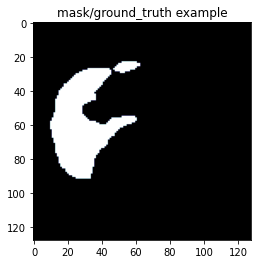

In [33]:
plt.imshow(masks_train_array[100], cmap=plt.cm.bone)  
plt.title('mask/ground_truth example')

Text(0.5, 1.0, 'original scan example')

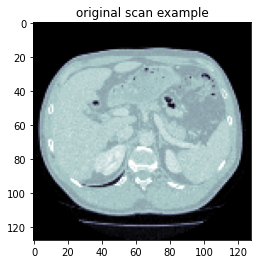

In [34]:
plt.imshow(orig_train_array[100], cmap=plt.cm.bone)  
plt.title('original scan example')

#### add channel dimension for model input: 

train data

In [35]:
orig_train_resh = orig_train_array.reshape(2518, 128, 128, -1)
orig_train_resh.shape, orig_train_resh.dtype

((2518, 128, 128, 1), dtype('float32'))

In [36]:
masks_train_resh = masks_train_array.reshape(2518, 128, 128, -1)
masks_train_resh.shape, masks_train_resh.dtype

((2518, 128, 128, 1), dtype('float32'))

test data

In [37]:
orig_test_resh = orig_test_array.reshape(133, 128, 128, -1)
orig_test_resh.shape, orig_test_resh.dtype

((133, 128, 128, 1), dtype('float32'))

In [38]:
masks_test_resh = masks_test_array.reshape(133, 128, 128, -1)
masks_test_resh.shape, masks_test_resh.dtype

((133, 128, 128, 1), dtype('float32'))

#### export train and test data to use on google colab

train data: 

In [ ]:
#orig_train_resh.dump('./X_train_19_patients_128big.pkl')

In [ ]:
#masks_train_resh.dump('./y_train_19_patients_128big.pkl')

test data: 

In [ ]:
#orig_test_resh.dump('./X_test_19_patients_128big.pkl')

In [ ]:
#masks_test_resh.dump('./y_test_19_patients_128big.pkl')